# COGS 108 - Data Cleaning Example
This notebook serves as an example of data cleaning using the vehicle stops data from 2014. Found here: https://data.sandiego.gov/datasets/police-vehicle-stops/

Feel free to add more and share thoughts!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## 1. Datasets

In [47]:
'''Stops'''
race_code = pd.read_csv('Data/vehicle_stops_race_codes.csv')
df_dict = pd.read_csv('Data/vehicle_stops_dictionary.csv')
stop_2014 = pd.read_csv('Data/vehicle_stops_2014_datasd_v1.csv')
stop_2015 = pd.read_csv('Data/vehicle_stops_2014_datasd_v1.csv')
stop_2016 = pd.read_csv('Data/vehicle_stops_2014_datasd_v1.csv')
stop_2017 = pd.read_csv('Data/vehicle_stops_2014_datasd_v1.csv')
stopAll = pd.concat([stop_2014, stop_2015, stop_2016, stop_2017])
stopAll.head()

'''Demographics'''

'Demographics'

#### Extract columns we intend to use, and rename for the purpose of convenience in manipulation.

In [48]:
stopAll = stopAll.loc[:, ['stop_id', 'stop_cause', 'service_area', 'subject_race', 'subject_sex', 'subject_age', 'date_stop', 'time_stop', 'arrested', 'searched']]
stopAll = stopAll.rename(columns = {'subject_race': 'race', 'subject_sex': 'sex', 'subject_age': 'age'})

## 2. Messy or unfaithful data
Does the data contain unrealistic or "incorrect" values?

#### 1. Check Data Types
    - Convert `date_time` column to datatime objects for better manipulations in the future
    - Convert `age` column to int by `stopAll['age'] = pd.to_numeric(stopAll['age'])`
        - However, some non-numeric values raised error. We'll see how to deal with them in the next step

In [50]:
stopAll.info() 
stopAll['date_stop'] = pd.to_datetime(stopAll['date_stop'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576656 entries, 0 to 144163
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stop_id       576656 non-null  int64         
 1   stop_cause    575808 non-null  object        
 2   service_area  576656 non-null  object        
 3   race          575768 non-null  object        
 4   sex           575896 non-null  object        
 5   age           563716 non-null  object        
 6   date_stop     576656 non-null  datetime64[ns]
 7   time_stop     574728 non-null  object        
 8   arrested      569172 non-null  object        
 9   searched      568348 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 48.4+ MB


#### 2. Unrealistic observations? Missing Values? 
    - Investigate columns of `race`, `sex`, and `age` 
    


- The values in `race` column are valid, except with null values. For the purpose of our study, we dropped the 222 observations with null races as followed. With a huge dataset, there won't be a big problem. 

In [51]:
stopAll.race.unique() 
stopAll = stopAll.loc[~stopAll['race'].isna(), :]
stopAll.reset_index(drop = True)

,stop_id,stop_cause,service_area,race,sex,age,date_stop,time_stop,arrested,searched
0,1044975,Moving Violation,110,W,M,24,2014-01-01,1:25,N,N
1,1044976,Moving Violation,320,W,M,42,2014-01-01,5:47,N,N
2,1044977,Moving Violation,320,L,M,29,2014-01-01,7:46,N,N
3,1044978,Moving Violation,610,W,M,23,2014-01-01,8:10,N,N
4,1044980,Equipment Violation,930,H,M,35,2014-01-01,8:35,N,N
...,...,...,...,...,...,...,...,...,...,...
575763,1189740,Moving Violation,440,B,F,54,2014-12-31,23:40,N,N
575764,1189744,Moving Violation,120,W,M,34,2014-12-31,23:40,N,N
575765,1189743,Moving Violation,510,H,M,39,2014-12-31,23:45,N,N
575766,1189750,Moving Violation,520,W,F,29,2014-12-31,23:49,N,N


- The values in `sex` column contain something we don't know:

    what is `X` in `array(['M', 'F', nan, 'X'], dtype=object)`? 

In [52]:
stopAll.sex.unique()

array(['M', 'F', nan, 'X'], dtype=object)

From the dictionary of our datasets, `X` is not expected:

In [53]:
df_dict.set_index('Field').loc['suject_sex']

Description        sex code
Possible Values        M, F
Name: suject_sex, dtype: object

- For now, we would just convert `X` to NaN for data consistency. We may drop the 23 observations later if we want to explore how gender is related to police's decisions of vehicle stops

In [54]:
stopAll[stopAll['sex'] == 'X']
stop_201b4 = stopAll.replace({'sex': {'X': np.NaN}})

- The values in `age` column have invalid values: too small or too large that are out of our common sense: 0, 2, 5, 185, 230, for example. Or something that aren't numeric: '5_', '4_', 'N', etc...
    For the latter ones, we'll just save them as nan

In [55]:
stopAll.age.unique() 
stopAll['age'] = pd.to_numeric(stopAll['age'], errors='coerce')

<ipython-input-55-f52a04da9c8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stopAll['age'] = pd.to_numeric(stopAll['age'], errors='coerce')


However, ages still range all over the place, from min 0.0 to max 255. Are these due to manual errors? Since currently we are not dealing with ages with vehicle stops, we'll leave it like this, but we'll keep in mind how the ages could influence the validity of our observations.

In [56]:
stopAll['age'].describe()
stopAll['age'].unique() 

array([ 24.,  42.,  29.,  23.,  35.,  30.,  19.,  32.,  36.,  27.,  16.,
        50.,  47.,  25.,  53.,  31.,  21.,  75.,  41.,  37.,  18.,  49.,
        82.,  40.,  17.,  33.,  22.,  43.,  48.,  44.,  nan,  62.,  38.,
        57.,  46.,  58.,  39.,  60.,  56.,  73.,  34.,  74.,  26.,  63.,
        54.,  55.,  68.,  28.,  65.,  20.,  45.,  52.,   0.,  64.,  70.,
        66.,  72.,  61.,  59.,  69.,  71.,  51.,  88.,  67.,  84.,  79.,
        77.,   5.,  81.,  83.,  97.,  89.,  78.,  76.,  90.,  87.,  85.,
        80., 230.,  86.,  93.,  15.,   2., 211.,  94.,   8., 234., 185.,
        13.,  12.,  92.,   9., 153.,   7.,  95.,  14.,  91.,   6.,   4.,
        10., 221.,   1., 255., 224.,   3.,  96., 204.,  99., 223., 228.,
       222., 200.])

#### 3. Data Granularity
As we observe previously, the race column has many correponding letters

In [57]:
stopAll.race.unique()

array(['W', 'L', 'H', 'V', 'B', 'A', 'O', 'C', 'F', 'Z', 'I', 'P', 'J',
       'X', 'K', 'U', 'G', 'S', 'D'], dtype=object)

In [58]:
# Race Code Dict
race_code

,Race Code,Description
0,A,OTHER ASIAN
1,B,BLACK
2,C,CHINESE
3,D,CAMBODIAN
4,F,FILIPINO
5,G,GUAMANIAN
6,H,HISPANIC
7,I,INDIAN
8,J,JAPANESE
9,K,KOREAN


The level of granularity of the races in our data right now seems inconsistent. 
For instance, 'WHITE' and 'BLACK' are much more broad than 'FILIPINO', 'JAPANESE', and 'GUAMANIAN'.
Therefore, we decided to adjust the granularity by manually defining each race code as followed:

In [59]:
race_dict = {'A':'Asian',
             'B':'Black',
             'C':'Asian',
             'D':'Asian',
             'F':'Asian',
             'G':'Asian',
             'H':'Hispanic',
             'I':'Native American',
             'J':'Asian',
             'K':'Asian',
             'L':'Asian',
             'O':'Other',
             'P':'Asian',
             'S':'Asian',
             'U':'Hawaiian',
             'V':'Asian',
             'W':'White',
             'Z':'Asian'
            }

In [60]:
race_code['Race_Category'] = race_code['Race Code'].replace(race_dict)
race_code

,Race Code,Description,Race_Category
0,A,OTHER ASIAN,Asian
1,B,BLACK,Black
2,C,CHINESE,Asian
3,D,CAMBODIAN,Asian
4,F,FILIPINO,Asian
5,G,GUAMANIAN,Asian
6,H,HISPANIC,Hispanic
7,I,INDIAN,Native American
8,J,JAPANESE,Asian
9,K,KOREAN,Asian


Join `stopAll` with the race code

In [61]:
stopAll = pd.merge(stopAll, race_code, left_on = 'race', right_on = 'Race Code', how = 'left')

In [62]:
stopAll

,stop_id,stop_cause,service_area,race,sex,age,date_stop,time_stop,arrested,searched,Race Code,Description,Race_Category
0,1044975,Moving Violation,110,W,M,24.0,2014-01-01,1:25,N,N,W,WHITE,White
1,1044976,Moving Violation,320,W,M,42.0,2014-01-01,5:47,N,N,W,WHITE,White
2,1044977,Moving Violation,320,L,M,29.0,2014-01-01,7:46,N,N,L,LAOTIAN,Asian
3,1044978,Moving Violation,610,W,M,23.0,2014-01-01,8:10,N,N,W,WHITE,White
4,1044980,Equipment Violation,930,H,M,35.0,2014-01-01,8:35,N,N,H,HISPANIC,Hispanic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575763,1189740,Moving Violation,440,B,F,54.0,2014-12-31,23:40,N,N,B,BLACK,Black
575764,1189744,Moving Violation,120,W,M,34.0,2014-12-31,23:40,N,N,W,WHITE,White
575765,1189743,Moving Violation,510,H,M,39.0,2014-12-31,23:45,N,N,H,HISPANIC,Hispanic
575766,1189750,Moving Violation,520,W,F,29.0,2014-12-31,23:49,N,N,W,WHITE,White


Now, we want to see how the distribution of race demographics is like in our dataset

In [63]:
dist = stopAll['Race_Category'].value_counts(normalize = True)
dist

White              0.431400
Hispanic           0.302748
Black              0.112338
Asian              0.085095
Other              0.062377
Native American    0.005847
Hawaiian           0.000195
Name: Race_Category, dtype: float64

[Text(0.5, 1.0, 'Racial Distribution in Police Stops Data')]

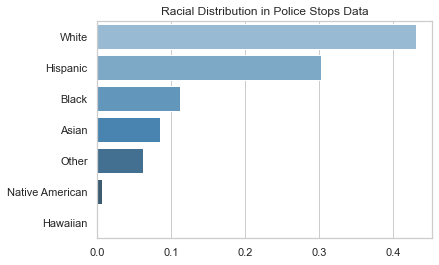

In [64]:
#Visualize the distribution
sns.set_theme(style="whitegrid")
title = "Racial Distribution in Police Stops Data"
sns.barplot(x = dist.values, y = dist.index, palette="Blues_d").set(title=title)

In [65]:
#How does this compare to the population demographic profiles at San Diego County?